# Usage Note: Visualizing the VitalDB Arrhythmia Database

This Jupyter Notebook provides a comprehensive guide on how to load and visualize electrocardiogram (ECG) waveforms and their corresponding annotations from the VitalDB Arrhythmia Database.

**Objective:**
To plot a specific time segment from a case, overlaying the raw ECG signal with its beat-by-beat annotations (Normal, Supraventricular, Ventricular) and overall rhythm labels.

**Annotation Files (`.csv`):** These files contain the detailed annotations for each beat and rhythm segment, reviewed by anesthesiologists[cite: 92].

**Required Libraries:**
* `vitaldb`: For reading `.vital` files.
* `pandas`: For handling the `.csv` annotation data.
* `numpy`: For numerical operations.
* `matplotlib`: For plotting the data.

## 1. Setup

### Installation
First, ensure you have all the necessary Python libraries installed. If not, you can install them by running the following command in your terminal or in a notebook cell.

In [ ]:
!pip install vitaldb pandas numpy matplotlib


### File Structure

For this script to work correctly, your files should be organized in the following directory structure. Place this Jupyter Notebook in your main project folder.

```
/your_project_folder/
├── LabelFile/metadata.csv                      # <-- metadata for Annotation files 
├── LabelFile/Annotation_Files_250907/          # <-- Directory for .csv annotation files
│   ├── Annotation_file_1.csv
│   ├── Annotation_file_2.csv
│   └── ...
└── Usage_Note.ipynb            # <-- This Jupyter Notebook
```

## 2. Import Libararies


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import vitaldb
import warnings

# Suppress unnecessary warnings for cleaner output
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

/Users/dain/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Libraries imported successfully!


## 3. Core Plotting Function

Here is the main function, `plot_segment`, which handles the visualization. This function is adapted from the script you provided and performs the following steps:

1.  **Selects a time window** of the ECG signal.
2.  **Plots the raw ECG waveform** for that window.
3.  **Highlights "Bad Signal Quality" regions** with a gray background, if any exist in the selected window.
4.  **Overlays beat markers** (`N`, `S`, `V`, `U`) at their precise time and amplitude on the ECG wave.
5.  **Draws arrows indicating the rhythm label** (e.g., 'Normal Sinus Rhythm', 'Atrial Fibrillation') across the top of the plot.

In [2]:
def plot_segment(ax, case_id, ecg_data, df, start_time, end_time, sample_rate=100):
    """
    Plots a segment of ECG data with its corresponding beat and rhythm annotations.
    """
    fs = sample_rate
    
    start_idx = int(start_time * fs)
    end_idx = int(end_time * fs)

    if start_idx < 0 or end_idx > len(ecg_data):
        print(f"  ⚠️ Index out of bounds for case {case_id}")
        return False

    ecg_segment = ecg_data[start_idx:end_idx]
    time_axis = np.arange(start_idx, end_idx) / fs
    
    if len(ecg_segment) == 0: 
        return False

    # Plot the raw ECG signal
    ax.plot(time_axis, ecg_segment, 'g-', alpha=0.8, linewidth=1.5, zorder=1)
    
    # Set plot aesthetics and Y-axis limits
    data_min, data_max = np.nanmin(ecg_segment), np.nanmax(ecg_segment)
    data_range = data_max - data_min
    if data_range < 1e-5: data_range = 1.0
    ax.set_ylim(data_min - data_range * 0.2, data_max + data_range * 0.4)
    
    # Filter annotations for the current segment
    if df is not None and not df.empty:
        segment_df = df[(df['time_second'] >= start_time - 1) & (df['time_second'] <= end_time + 1)]

        # 1. Highlight "Bad Signal Quality" regions
        if 'bad_signal_quality' in segment_df.columns and segment_df['bad_signal_quality'].any():
            bad_times = segment_df[segment_df['bad_signal_quality'] == True]['time_second'].sort_values()
            if not bad_times.empty:
                # Group consecutive bad signal points into continuous blocks
                groups = []
                current_group = [bad_times.iloc[0]]
                for i in range(1, len(bad_times)):
                    if bad_times.iloc[i] - bad_times.iloc[i-1] <= 2.0: # Group if points are <= 2s apart
                        current_group.append(bad_times.iloc[i])
                    else:
                        groups.append(current_group)
                        current_group = [bad_times.iloc[i]]
                groups.append(current_group)
                
                # Draw a shaded rectangle for each block
                for group in groups:
                    if len(group) >= 2:
                        group_start = max(group[0], start_time)
                        group_end = min(group[-1], end_time)
                        ax.axvspan(group_start, group_end, color='lightgray', alpha=0.5, zorder=0)

        # 2. Overlay Beat Markers
        beat_shapes = {'N': 'o', 'S': '^', 'V': 's', 'U': '*'}
        valid_beats = segment_df[(segment_df['time_second'] >= start_time) & (segment_df['time_second'] < end_time)]
        if not valid_beats.empty and 'beat_type' in valid_beats.columns:
            for _, beat_row in valid_beats.iterrows():
                beat_time = beat_row['time_second']
                beat_type = beat_row['beat_type']
                if pd.notna(beat_type):
                    sample_idx = int((beat_time - start_time) * fs)
                    if 0 <= sample_idx < len(ecg_segment):
                        beat_amp = ecg_segment[sample_idx]
                        shape = beat_shapes.get(beat_type, 'x')
                        ax.scatter(beat_time, beat_amp, s=60, c='black', marker=shape, alpha=0.9, zorder=2)

        # 3. Annotate Rhythm Labels
        if 'rhythm_label' in segment_df.columns:
            rhythm_data = segment_df[segment_df['rhythm_label'].notna() & (segment_df['rhythm_label'] != '')].copy()
            if not rhythm_data.empty:
                rhythm_data['block'] = (rhythm_data['rhythm_label'] != rhythm_data['rhythm_label'].shift()).cumsum()
                y_pos = data_max + data_range * 0.15
                for _, block in rhythm_data.groupby(['rhythm_label', 'block']):
                    r_start = max(block['time_second'].min(), start_time)
                    r_end = min(block['time_second'].max(), end_time)
                    if r_start < r_end:
                        ax.annotate('', xy=(r_start, y_pos), xytext=(r_end, y_pos), 
                                   arrowprops=dict(arrowstyle='<->', color='black', lw=1.5))
                        ax.text((r_start + r_end) / 2, y_pos + data_range * 0.02, block['rhythm_label'].iloc[0], 
                               ha='center', va='bottom', color='black', fontsize=11, fontweight='bold')
    
    # Finalize plot
    ax.set_title(f"Case ID: {case_id}", fontsize=16)
    ax.set_xlabel("Time (seconds)", fontsize=12)
    ax.set_ylabel("Amplitude (mV)", fontsize=12)
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_xlim(start_time, end_time)

    beat_shapes = {'N': 'o', 'S': '^', 'V': 's', 'U': '*'}
    beat_labels = {
        'N': 'N : Normal',
        'S': 'S : Supraventricular',
        'V': 'V : Ventricular',
        'U': 'U : Unclassifiable'
    }
    legend_elements = [Line2D([0], [0], marker=shape, color='w', label=label,
                              markerfacecolor='black', markersize=9)
                       for beat, shape in beat_shapes.items()
                       for code, label in beat_labels.items() if code == beat]
    legend_elements.append(Patch(facecolor='lightgray', alpha=0.5, label='bad signal quality'))
    ax.legend(handles=legend_elements, loc='upper right', fontsize=11)

    # 5. Show the plot
    plt.tight_layout()
    



## 4. Plot Example Case 

Successfully loaded data for Case ID: 3623
Total ECG data points: 1118380
First 5 rows of the annotation file:


,time_second,beat_type,rhythm_label,bad_signal_quality,bad_signal_quality_label
0,20.394444,N,N,False,NaN
1,21.216667,N,N,False,NaN
2,22.038889,N,N,False,NaN
3,22.863889,N,N,False,NaN
4,23.677778,N,N,False,NaN


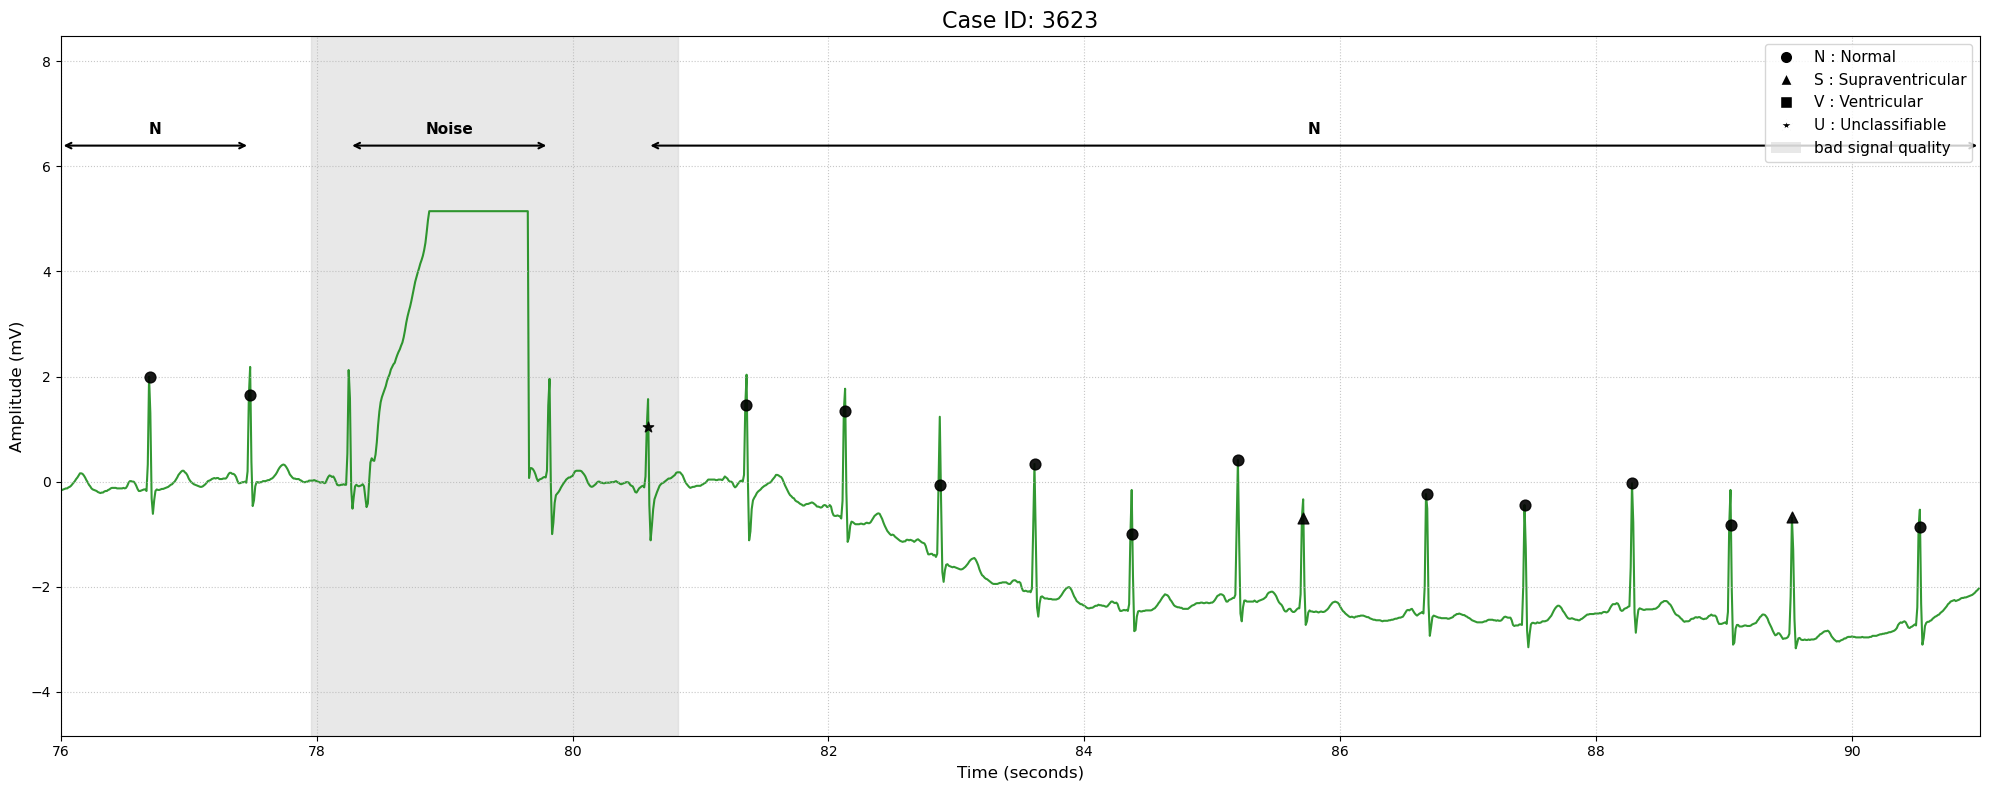

In [3]:

# --- Configuration ---

# [INPUT] Set the directories where your data is stored
PROCESSED_LABEL_DIR = "./LabelFile//Annotation_Files_250907"

# Select a sample case to visualize
# [cite_start]We will use case_id '337' as an example, which is featured in Figure 1 of the paper[cite: 64].
CASE_ID = 3623
START_TIME_SECS = 76
SEGMENT_DURATION_SECS = 8
SAMPLE_RATE = 100 
# --- Load Data ---

# Construct the full paths to the data files
csv_path = os.path.join(PROCESSED_LABEL_DIR, f"Annotation_file_{CASE_ID}.csv")


# Load the annotation data using pandas
df_labels = pd.read_csv(csv_path)

# Load the raw ECG waveform data using the vitaldb library
# We will load the 'ECG_II' track at a sampling frequency of 100 Hz
vf = vitaldb.VitalFile(CASE_ID)
ecg_data = vf.to_numpy(['ECG_II'], 1/SAMPLE_RATE)[:, 0]

print(f"Successfully loaded data for Case ID: {CASE_ID}")
print(f"Total ECG data points: {len(ecg_data)}")
print("First 5 rows of the annotation file:")
display(df_labels.head())
# Create the plot
fig, ax = plt.subplots(figsize=(20, 8))

# Call the plotting function
plot_segment(ax,
             case_id=CASE_ID,
             ecg_data=ecg_data,
             df=df_labels,

             start_time=START_TIME_SECS,
             end_time =START_TIME_SECS + 15, 
             sample_rate = SAMPLE_RATE )

# Display the plot
plt.show()

## 5. Example: Finding and Plotting a Specific Arrhythmia (SVTA)

The `metadata.csv` file is a powerful tool for quickly finding cases with specific characteristics without having to load every large annotation file.

In this example, we will:
1.  Load the `metadata.csv` file.
2.  Search for all cases that contain the rhythm 'Supraventricular Tachyarrhythmia'.
3.  Select one of those cases.
4.  Find the exact moment the SVTA occurs and plot a 15-second window around it.

In [4]:
# --- 1. Load the Metadata File ---
METADATA_FILE = "./LabelFile/metadata.csv"

try:
    metadata_df = pd.read_csv(METADATA_FILE)
    print("Successfully loaded metadata.csv. Here are the first 5 rows:")
    display(metadata_df.head())
except FileNotFoundError:
    print(f"❌ Error: '{METADATA_FILE}' not found. Please run the metadata generation script first.")

Successfully loaded metadata.csv. Here are the first 5 rows:


,case_id,analysis_start_time_sec,analysis_end_time_sec,analyzed_duration_sec,total_beats,rhythm_classes
0,1001,4993.494444,6188.511111,1195.016667,1047,"N, SR-mPVC-BT"
1,1002,6153.197222,7352.455556,1199.258333,1466,"N, Noise, SVTA"
2,1018,1523.447222,2541.350000,1017.902778,1087,"N, SVTA, VT"
3,1023,3001.583333,4304.436111,1302.852778,1341,"AFIB/AFL, Noise"
4,103,275.705556,1469.844444,1194.138889,1234,"N, Noise, SR-mPAC-BT, VT"


### Step 2 & 3: Find Cases with SVTA and Select One
Now, we'll filter the DataFrame to find rows where the `rhythm_classes` column contains the text 'Supraventricular Tachyarrhythmia'. From the filtered results, we'll select the first `case_id` as our example.

In [5]:
# --- 2. Find all cases containing the target rhythm ---
target_rhythm = "SVTA"
svta_cases = metadata_df[metadata_df['rhythm_classes'].str.contains(target_rhythm, na=False)]

if svta_cases.empty:
    print(f"❌ No cases found with the rhythm: '{target_rhythm}'")
else:
    print(f"Found {len(svta_cases)} cases with '{target_rhythm}':")
    display(svta_cases[['case_id', 'rhythm_classes']].head())

    # --- 3. Select the first case as our example ---
    example_case_id = svta_cases['case_id'].iloc[0]
    print(f"\nSelecting Case ID: {example_case_id} for plotting.")

Found 109 cases with 'SVTA':


,case_id,rhythm_classes
1,1002,"N, Noise, SVTA"
2,1018,"N, SVTA, VT"
7,1083,"N, Noise, SVTA, VT"
30,1375,"N, SVTA"
38,146,"N, Noise, SR-mPVC-BT, SVTA, Unclassifiable, VT"



Selecting Case ID: 1002 for plotting.


### Step 4: Find the SVTA Segment and Plot It
With our `example_case_id`, we can now load its detailed annotation file to find the precise start time of the SVTA event. We will then use our `plot_segment` function to visualize it.

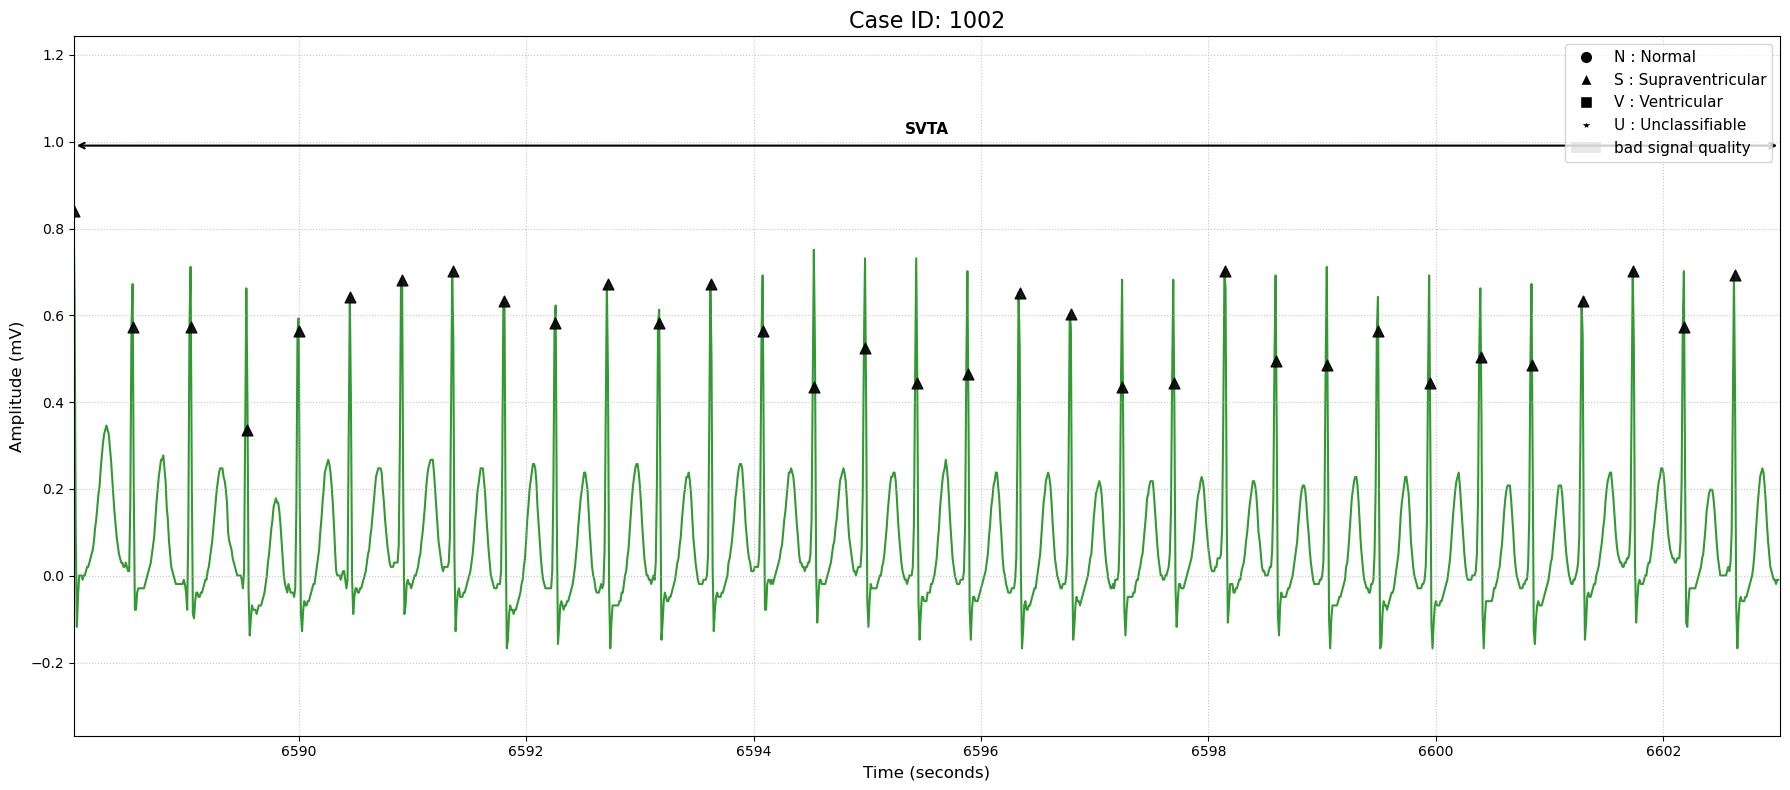

In [6]:
# --- 4. Find the specific time of the SVTA event and plot it ---

if 'example_case_id' in locals() and example_case_id:
    try:
        # Load the detailed annotation file for the selected case (from local folder)
        case_id_str = str(example_case_id)
        annotation_path = os.path.join(PROCESSED_LABEL_DIR, f"Annotation_file_{case_id_str}.csv")
        case_df = pd.read_csv(annotation_path)

        # Find all rows with the target rhythm
        svta_segments = case_df[case_df['rhythm_label'] == target_rhythm]

        if not svta_segments.empty:
            # Get the start time of the first SVTA event
            start_time = svta_segments['time_second'].iloc[0]
            
            # --- Load the waveform data directly via API and create the plot ---
            print(f"Downloading waveform data for case {example_case_id} via API...")
            
            # The vitaldb library fetches the data from the server using the case ID
            vf = vitaldb.VitalFile(int(example_case_id))
            ecg_data = vf.to_numpy(['ECG_II'], 1/100)[:, 0]

            fig, ax = plt.subplots(figsize=(18, 8))
            
            # Plot a 15-second window starting from the event
            plot_segment(ax, case_id_str, ecg_data, case_df, start_time, start_time + 15, sample_rate=100)
            
            # --- ADDED DEFINITIONS HERE ---
            # Define the shapes and labels for the legend
            beat_shapes = {'N': 'o', 'S': '^', 'V': 's', 'U': '*'}
            beat_labels = {
                'N': 'N : Normal',
                'S': 'S : Supraventricular',
                'V': 'V : Ventricular',
                'U': 'U : Unclassifiable'
            }
            # --- END OF ADDED DEFINITIONS ---

            # Add the legend
            legend_elements = [Line2D([0], [0], marker=shape, color='w', label=label,
                                      markerfacecolor='black', markersize=9)
                               for beat, shape in beat_shapes.items()
                               for code, label in beat_labels.items() if code == beat]
            legend_elements.append(Patch(facecolor='lightgray', alpha=0.5, label='bad signal quality'))
            ax.legend(handles=legend_elements, loc='upper right', fontsize=11)
            
            plt.tight_layout()
            plt.show()

        else:
            print(f"Could not find a specific segment labeled '{target_rhythm}' in case {example_case_id}.")

    except FileNotFoundError:
        print(f"❌ Error: Annotation file not found for case {example_case_id}. Check your PROCESSED_LABEL_DIR path.")
    except Exception as e:
        print(f"An error occurred: {e}")